In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime
from dateutil import tz

In [2]:
with open('../config.json', 'r') as config_file:
    config = json.load(config_file)

df = pd.read_csv(os.path.join(config['data_path'], 'full_kpis.csv'), index_col=0)
print(df.shape)
df.head()

(10883795, 11)


,timestamp,cell,bts,antenna,carrier,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
0,2023-09-01 02:30:00,187_0_0,187,0,0,-104.87,156.0,1.685871,108.571429,115.428571,0
1,2023-09-01 02:30:00,187_0_1,187,0,1,-104.75,141.0,1.441159,50.844828,53.931034,0
2,2023-09-01 02:30:00,187_1_0,187,1,0,-101.90,39.0,0.816284,208.000000,218.500000,0
3,2023-09-01 02:30:00,187_1_1,187,1,1,-101.73,53.0,0.800664,411.500000,432.750000,0
4,2023-09-01 02:30:00,187_2_0,187,2,0,-105.03,143.0,1.126611,79.933333,85.166667,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10883795 entries, 0 to 14305622
Data columns (total 11 columns):
 #   Column           Dtype  
---  ------           -----  
 0   timestamp        object 
 1   cell             object 
 2   bts              int64  
 3   antenna          int64  
 4   carrier          int64  
 5   minRSSI          float64
 6   pageSessions     float64
 7   ULvol            float64
 8   sessionSetupDur  float64
 9   sessionDur       float64
 10  blocks           int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 996.4+ MB


In [4]:
kpis = [col for col in df.columns if col not in ['timestamp', 'cell', 'bts', 'antenna', 'carrier']]

In [5]:
df[kpis].describe().apply(lambda x: x.apply(lambda y: f"{y:.2f}"))

,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
count,10883795.00,10883795.00,10883795.00,10883795.00,10883795.00,10883795.00
mean,-105.87,123.98,0.99,50.15,53.31,0.04
std,3.18,184.76,1.55,104.76,110.59,4.70
min,-136.17,1.00,0.00,0.00,0.00,0.00
25%,-108.03,15.00,0.08,8.56,9.26,0.00
50%,-106.33,53.00,0.28,17.24,18.54,0.00
75%,-104.31,158.00,1.29,52.62,56.12,0.00
max,-62.81,4237.00,45.29,6540.00,6925.00,5062.00


In [6]:
# Show how many bts have two carriers and how many have one carrier
df.groupby('bts').agg({'carrier': 'nunique'}).carrier.value_counts()

1    100
2     61
Name: carrier, dtype: int64

In [7]:
# Check the amount of BTS+antenna combinations
df.groupby(['bts', 'antenna']).size().count()

417

In [8]:
# Check the amount of unique cells
df.cell.nunique()

588

# Visualize

In [9]:
def plot_bts_kpi(df, bts, kpi='minRSSI'):
    # Filter the dataframe for the selected BTS
    df_bts = df[df['bts'] == bts].copy()
    
    # Convert timestamp to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(df_bts['timestamp']):
        df_bts['timestamp'] = pd.to_datetime(df_bts['timestamp'])
    
    # Set up the plot
    #plt.figure(figsize=(16, 8))
    plt.figure(figsize=(12, 6))
    
    # Color map for antennas
    colors = ['blue', 'green', 'red']
    
    # Plot for each antenna and carrier
    for antenna in df_bts['antenna'].unique():
        for carrier in df_bts['carrier'].unique():
            data = df_bts[(df_bts['antenna'] == antenna) & (df_bts['carrier'] == carrier)]
            
            if not data.empty:
                color = colors[antenna]
                linestyle = '--' if carrier == 0 else '-'
                
                plt.plot(data['timestamp'], data[kpi], 
                         linestyle=linestyle, color=color, 
                         label=f'Antenna {antenna}, Carrier {carrier}')
    
    # Customize the plot
    #plt.title(f'{kpi} for BTS {bts}')
    plt.xlabel('Date')
    plt.ylabel(kpi)
    
    # Set x-axis ticks to show date once in 2 weeks
    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=4))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Make a less dense grid
    plt.grid(True, which='major', linestyle='--', color='gray', alpha=0.5)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

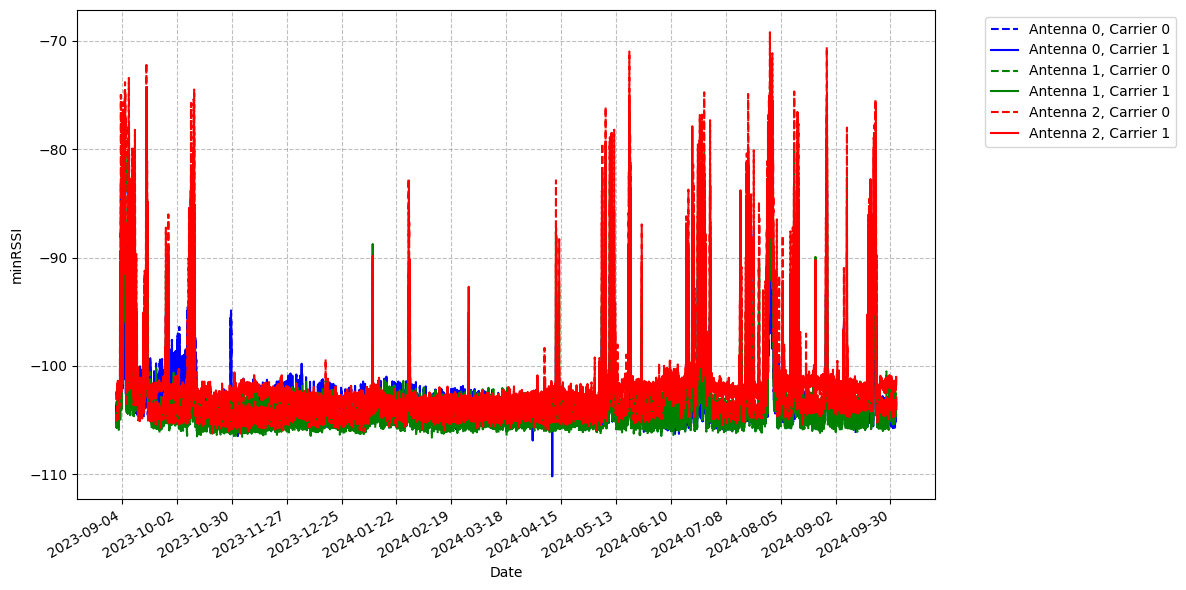

In [10]:
plot_bts_kpi(df, 180, 'minRSSI')

## Time series analysis

### Seasonality

https://medium.com/@datasciencewizards/preprocessing-and-data-exploration-for-time-series-decomposing-time-series-a44e074c5847

In [11]:
# convert timestamp to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [12]:
# Resample to daily frequency and calculate mean KPIs
daily_data = df.resample('D').agg({kpi: 'mean' for kpi in kpis})
daily_data.head()

,minRSSI,pageSessions,ULvol,sessionSetupDur,sessionDur,blocks
timestamp,,,,,,
2023-09-01,-105.996865,170.800368,0.909993,63.949750,69.162130,0.014342
2023-09-02,-105.978222,152.480063,0.823289,61.076722,65.719679,0.003944
2023-09-03,-103.649734,161.912400,0.843474,66.222623,71.590561,0.000930
2023-09-04,-102.694032,159.200520,0.822408,61.159700,66.135534,0.002527
2023-09-05,-101.762157,152.575726,0.822281,56.383442,60.783143,0.001494


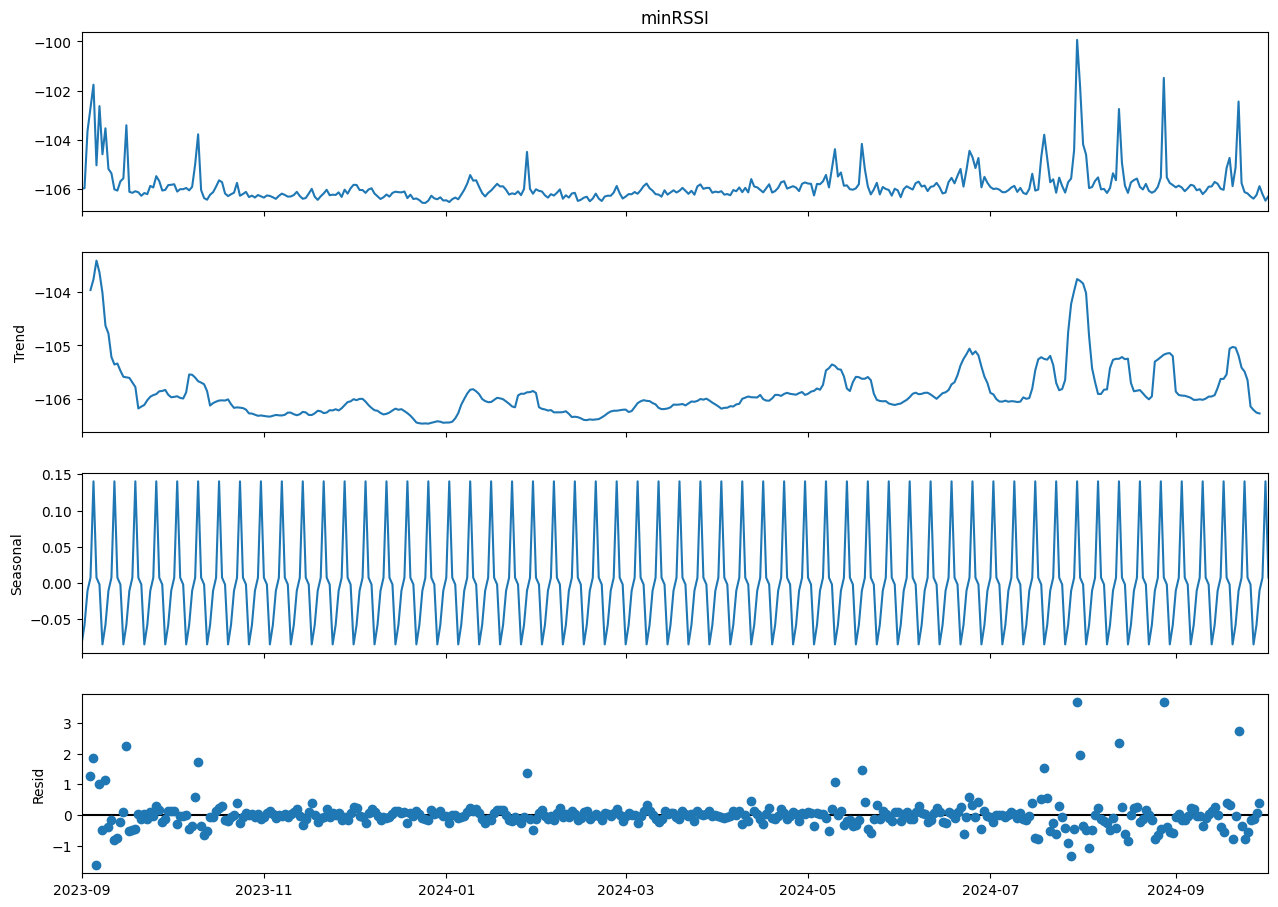

In [13]:
# Perform decomposition
decomposition1 = seasonal_decompose(daily_data['minRSSI'], model='additive', period=7)

# Plot the decomposition
fig = decomposition1.plot()
fig.set_size_inches(14, 10)
plt.show()

### Temporal patterns

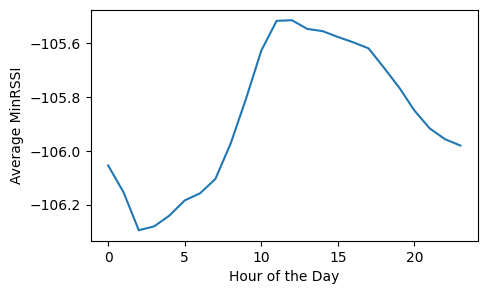

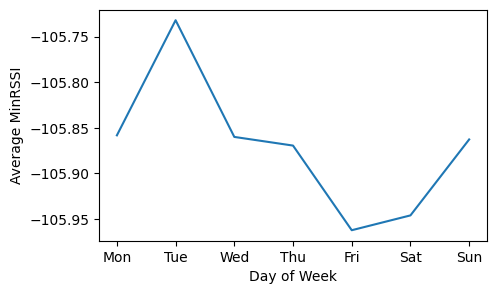

In [14]:
# Daily pattern
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')['minRSSI'].mean()
hourly_avg.plot(kind='line', figsize=(5, 3))
plt.xlabel('Hour of the Day')
plt.ylabel('Average MinRSSI')
plt.show()

# Weekly pattern
df['dayofweek'] = df.index.dayofweek
weekly_avg = df.groupby('dayofweek')['minRSSI'].mean()
weekly_avg.plot(kind='line', figsize=(5, 3))
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(range(7), days)
plt.xlabel('Day of Week')
plt.ylabel('Average MinRSSI')
plt.show()

In [15]:
from scipy.stats import f_oneway

# ANOVA test for daily pattern
daily_anova = f_oneway(*[daily_data[daily_data.index.dayofweek == i]['minRSSI'] for i in range(7)])
print(f"Daily Pattern ANOVA: F-statistic = {daily_anova.statistic}, p-value = {daily_anova.pvalue}")

# ANOVA test for weekly pattern using isocalendar().week
weekly_anova = f_oneway(*[daily_data[daily_data.index.isocalendar().week == i]['minRSSI'] for i in range(1, daily_data.index.isocalendar().week.max() + 1)])
print(f"Weekly Pattern ANOVA: F-statistic = {weekly_anova.statistic}, p-value = {weekly_anova.pvalue}")

Daily Pattern ANOVA: F-statistic = 0.5670975943995802, p-value = 0.7565428975552005
Weekly Pattern ANOVA: F-statistic = 4.354583941471173, p-value = 8.931946424140332e-17


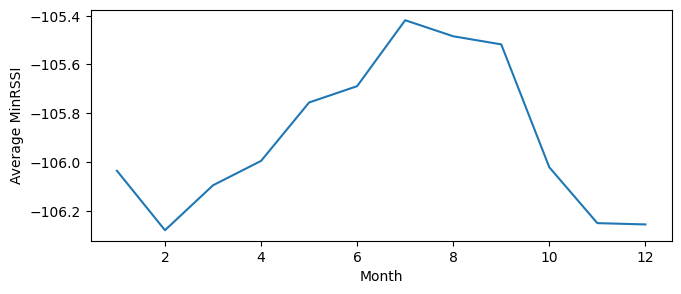

In [16]:
# Monthly pattern
df['month'] = df.index.month
monthly_avg = df.groupby('month')['minRSSI'].mean()
monthly_avg.plot(kind='line', figsize=(7.5, 3))
plt.xlabel('Month')
plt.ylabel('Average MinRSSI')
plt.show()

In [17]:
# Perform ANOVA test on monthly average minRSSI
monthly_anova = f_oneway(*[df[df['month'] == i]['minRSSI'] for i in range(1, 13)])
print(f"Monthly Pattern ANOVA: F-statistic = {monthly_anova.statistic}, p-value = {monthly_anova.pvalue}")

Monthly Pattern ANOVA: F-statistic = 9251.410895065274, p-value = 0.0


### Monthly variance

In [19]:
df.reset_index(inplace=True)

In [20]:
# Extract year and month from the timestamp
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Group by year and month and calculate the variance of minRSSI
monthly_var_with_year = df.groupby(['year', 'month'])['minRSSI'].var()

# Display the result
monthly_var_with_year

year  month
2023  9        14.540772
      10       10.060072
      11        8.584307
      12        8.345765
2024  1         8.931013
      2         8.121529
      3         8.234680
      4         8.343636
      5         9.696547
      6         9.858412
      7        13.826462
      8        11.990127
      9         9.864347
      10        6.544227
Name: minRSSI, dtype: float64

## Correlation and distribution

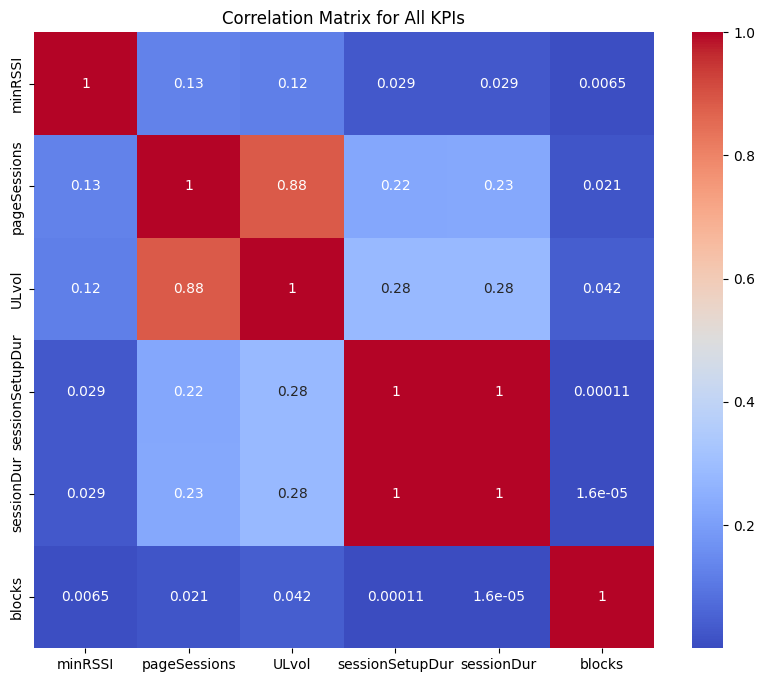

In [21]:
# Calculate the correlation matrix for all KPIs
correlation_matrix = df[kpis].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for All KPIs')
plt.show()

**sessionSetupDur** and **sessionDur** are too similar, so drop one of them. **blocks** is not correlated with any other KPIs, drop it too.

In [28]:
kpis = ['minRSSI', 'pageSessions', 'ULvol', 'sessionDur']

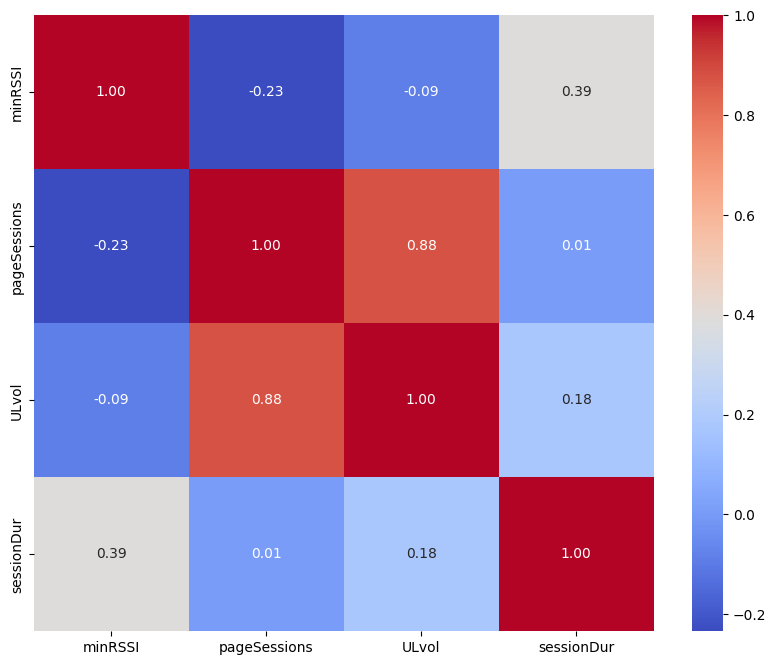

In [29]:
# Filter the dataframe for the selected BTS
sel_bts = 190
df_sel_bts = df[df['bts'] == sel_bts]

# Calculate the correlation matrix for all KPIs for the selected BTS
correlation_matrix_sel_bts = df_sel_bts[kpis].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_sel_bts, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

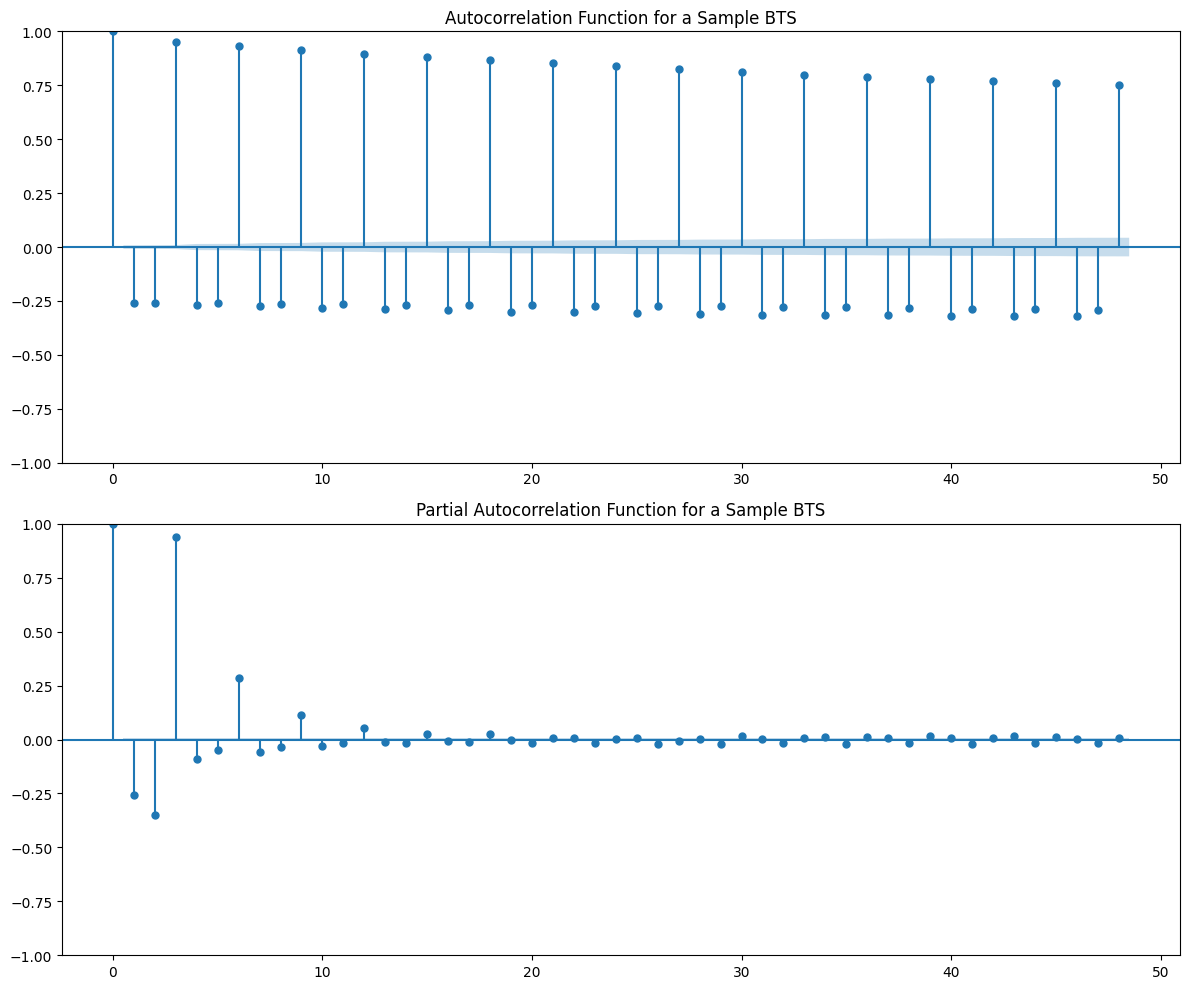

In [31]:
def plot_acf_pacf_for_bts(df, bts, lags=48):
    # Filter the dataframe for the selected BTS
    df_bts = df[df['bts'] == bts].copy()
    
    # Plot ACF and PACF
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    plot_acf(df_bts['minRSSI'], ax=ax1, lags=lags)
    ax1.set_title(f'Autocorrelation Function for a Sample BTS')
    plot_pacf(df_bts['minRSSI'], ax=ax2, lags=lags)
    ax2.set_title(f'Partial Autocorrelation Function for a Sample BTS')
    plt.tight_layout()
    plt.show()

# Example usage
plot_acf_pacf_for_bts(df, 190)